# imports

In [ ]:
!pip install gensim
!pip install pyLDAvis

In [ ]:
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import spacy
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'gensim'

In [ ]:
from google.colab import userdata
key = userdata.get('wu-key')
deepkey = userdata.get('wu-deepinfra')

from openai import OpenAI
client = OpenAI(api_key = key)
llama = OpenAI(
    api_key=deepkey,
    base_url="https://api.deepinfra.com/v1/openai",
)

In [ ]:
def AIquery(model, n, prompt):
  msg = client.chat.completions.create(
    model=model,
    n=n,
    messages=[{"role": "user", "content": prompt}]
  )
  return msg.choices[0].message.content

def AIHistoryquery(history_prompt, history_response, prompt):
  msg = client.chat.completions.create(
    model='gpt-4o-mini',
    n=1,
    messages=[{"role": "user", "content": history_prompt},
    {"role": "assistant", "content": history_response},
    {"role": "user", "content": prompt}]
  )
  return msg.choices[0].message.content

In [ ]:
def LlamaQuery(prompt):
  msg = llama.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct",
    messages=[{"role": "user", "content": prompt}],
  )
  return msg.choices[0].message.content

def LlamaHistoryquery(history_prompt, history_response, prompt):
  msg = llama.chat.completions.create(
    model="meta-llama/Llama-3.3-70B-Instruct",
    n=1,
    messages=[{"role": "user", "content": history_prompt},
    {"role": "assistant", "content": history_response},
    {"role": "user", "content": prompt}]
  )
  return msg.choices[0].message.content

In [ ]:
def MistralQuery(prompt):
  msg = llama.chat.completions.create(
    model="mistralai/Mistral-Small-3.2-24B-Instruct-2506",
    messages=[{"role": "user", "content": prompt}],
  )
  return msg.choices[0].message.content

def MistralHistoryquery(history_prompt, history_response, prompt):
  msg = llama.chat.completions.create(
    model="mistralai/Mistral-Small-3.2-24B-Instruct-2506",
    n=1,
    messages=[{"role": "user", "content": history_prompt},
    {"role": "assistant", "content": history_response},
    {"role": "user", "content": prompt}]
  )
  return msg.choices[0].message.content

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data_path = '/content/drive/MyDrive/LLM Explanation Diff/Raw Data/offensiveness_raw.csv'
offensiveness_data = pd.read_csv(data_path)

data_path = '/content/drive/MyDrive/raw_data(1).csv'
politeness_data = pd.read_csv(data_path)

data_path = '/content/drive/MyDrive/potato_dataset_llm.csv'
potato_data = pd.read_csv(data_path)

#politeness_csv = pd.read_csv('/content/potato_politeness_dataset_llm.csv')

Mounted at /content/drive


In [ ]:
unique_instance = []
offensiveness = []
counts = []
unique_posts = []

for index, row in offensiveness_data.iterrows():
  if row['instance_id'] not in unique_instance:
    unique_instance.append(row['instance_id'])
    offensiveness.append(row['offensiveness'])
    unique_posts.append(row['text'])
    counts.append(1)
  else:
    counts[unique_instance.index(row['instance_id'])] += 1
    offensiveness[unique_instance.index(row['instance_id'])] += row['offensiveness']

for x in range(len(offensiveness)):
  offensiveness[x] = float(offensiveness[x] / counts[x])

In [ ]:
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from gensim import corpora
nltk.download('stopwords')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
import re

import spacy
nlp = spacy.load('en_core_web_sm')


def preprocess(texts):
  texts = [re.sub(r'[^\w\s]', '', text) for text in texts]
  docs = [nlp(text) for text in texts]#nlp(text)
  lemmatized_tokens = [[token.lemma_ for token in doc] for doc in docs]
  text = [' '.join(lemmatized_token) for lemmatized_token in lemmatized_tokens]

  texts = [[word for word in document.lower().split() if word not in stop_words]
      for document in text]

  frequency = defaultdict(int)
  for text in texts:
      for token in text:
          frequency[token] += 1

  texts = [
      [token for token in text if frequency[token] > 1]
      for text in texts]

  dictionary = corpora.Dictionary(texts)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# llm querying


In [ ]:
llm_noexplanation = []
for x in unique_posts:
  llm_noexplanation.append(AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive. Do not explain why, only give a numerical score on the range 1-5"))

In [ ]:
llm_explanation = []
llm_explanation_text = []

for x in unique_posts:
  response = AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive")
  llm_explanation_text.append(response)
  response1 = AIHistoryquery("Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive", response, "Based on the above explanation, what is a numerical score of offensiveness from 1 to 5?")
  llm_explanation.append(response1)

In [ ]:
df = pd.DataFrame({'text post': unique_posts, 'no explanation': llm_noexplanation, 'explanation': llm_explanation_text, 'explanation ranking': llm_explanation})

explanation_scores = []
for index, row in df.iterrows():
  try:
    explanation_scores.append(int(re.findall(r'\d+', row['explanation ranking'])[0]))
  except:
    explanation_scores.append(-1)

In [ ]:
ids = []
for index, row in df.iterrows():
  ids.append(unique_instance[unique_posts.index(row['text post'])])

In [ ]:
df['id'] = ids
df['explanation scores'] = explanation_scores
df['mean ranking'] = offensiveness

In [ ]:
df.to_csv('potato_dataset_llm.csv', index=False)

In [ ]:
llm_summary = []
llm_summary_text = []

for x in unique_posts:
  response = AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + x + "\"\n\nSummarize the offensiveness (if present) in the above text.")
  llm_summary_text.append(response)
  response1 = AIHistoryquery("Text: \"" + x + "\"\n\nSummarize the offensiveness (if present) in the above text.", response, "Based on the original text and summary above, what is a numerical score of offensiveness from 1 to 5? Do not explain why.")
  llm_summary.append(response1)
  print(response + "\n" + response1)

The text does not contain any offensive language or content. It expresses a personal opinion about Dethklok songs and a recommendation regarding their tuning, which is neutral and non-offensive.
1
The text contains offensive elements, particularly in its generalized portrayal of Muslim individuals and the suggestion that they are more likely to be involved in terrorism, specifically targeting airlines. This reinforces harmful stereotypes and scapegoating, implying that all Muslims are potential threats. Additionally, the notion of the airline "painting a bright red bullseye" on its planes perpetuates fear and prejudice, contributing to a climate of distrust and anxiety around specific communities. Overall, the language used reflects a prejudice that maligns a group based on the actions of a few, fostering an environment of discrimination and hostility.
4
The text contains offensive language and stereotypes. Describing the German man as having a "shitty mustache" is derogatory and contr

In [ ]:
df.to_csv('potato_offensiveness_llm.csv', index = False)

# llama offensiveness query

In [ ]:
llm_noexplanation = []
for x in unique_posts:
  llm_noexplanation.append(LlamaQuery(prompt = "Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive. Do not explain why, only give a numerical score on the range 1-5"))

In [ ]:
llm_explanation = []
llm_explanation_text = []

for x in unique_posts:
  response = LlamaQuery(prompt = "Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive")
  llm_explanation_text.append(response)
  response1 = LlamaHistoryquery("Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive", response, "Based on the above explanation, what is a numerical score of offensiveness from 1 to 5?")
  llm_explanation.append(response1)

In [ ]:
df = pd.DataFrame({'text post': unique_posts, 'no explanation': llm_noexplanation, 'explanation': llm_explanation_text, 'explanation ranking': llm_explanation})

explanation_scores = []
for index, row in df.iterrows():
  try:
    explanation_scores.append(int(re.findall(r'\d+', row['explanation ranking'])[0]))
  except:
    explanation_scores.append(-1)

ids = []
for index, row in df.iterrows():
  ids.append(unique_instance[unique_posts.index(row['text post'])])

df['id'] = ids
df['explanation scores'] = explanation_scores
df['mean ranking'] = offensiveness

df.to_csv('potato_dataset_llamallm.csv', index=False)

# mistral offensiveness


In [ ]:
llm_noexplanation = []
for x in unique_posts:
  llm_noexplanation.append(MistralQuery(prompt = "Text: \"" + x  + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive. Do not explain why, only give a numerical score on the range 1-5"))

In [ ]:
llm_explanation = []
llm_explanation_text = []

for x in unique_posts:
  response = MistralQuery(prompt = "Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive")
  llm_explanation_text.append(response)
  response1 = MistralHistoryquery("Text: \"" + x + "\"\n\nRank the above piece of text on an offensiveness scale from 1-5 where 1 is not offensive at all and 5 is very offensive", response, "Based on the above explanation, what is a numerical score of offensiveness from 1 to 5?")
  llm_explanation.append(response1)

In [ ]:
df = pd.DataFrame({'text post': unique_posts, 'no explanation': llm_noexplanation, 'explanation': llm_explanation_text, 'explanation ranking': llm_explanation})

explanation_scores = []
for index, row in df.iterrows():
  try:
    explanation_scores.append(int(re.findall(r'\d+', row['explanation ranking'])[0]))
  except:
    explanation_scores.append(-1)

ids = []
for index, row in df.iterrows():
  ids.append(unique_instance[unique_posts.index(row['text post'])])

df['id'] = ids
df['explanation scores'] = explanation_scores
df['mean ranking'] = offensiveness

df.to_csv('potato_dataset_mistralllm.csv', index=False)

# politeness query

In [ ]:
unique_instance = []
politeness = []
counts = []
unique_posts = []

for index, row in politeness_data.iterrows():
  if row['instance_id'] not in unique_instance:
    unique_instance.append(row['instance_id'])
    politeness.append(row['politeness'])
    unique_posts.append(row['text'])
    counts.append(1)
  else:
    counts[unique_instance.index(row['instance_id'])] += 1
    politeness[unique_instance.index(row['instance_id'])] += row['politeness']

for x in range(len(politeness)):
  politeness[x] = float(politeness[x] / counts[x])

In [ ]:
llm_noexplanation = []
for x in unique_posts:
  llm_noexplanation.append(LlamaQuery("Text: \"" + x + "\"\n\nRank the above piece of text on an politeness scale from 1-5 where 1 is not polite at all and 5 is very polite. Do not explain why, only give a numerical score on the range 1-5"))

In [ ]:
df = pd.read_csv('potato_politeness_dataset_mistral.csv')

In [ ]:
df

NameError: name 'df' is not defined

In [ ]:
llm_explanation = []
llm_explanation_text = []

for index, row in df.iterrows():
  if(len(row['explanation']) != 1):
    llm_explanation.append(row['explanation ranking'])
    llm_explanation_text.append(row['explanation'])

NameError: name 'df' is not defined

In [ ]:
for x in range(len(unique_posts)):
  response = LlamaQuery(prompt = "Text: \"" + unique_posts[x] + "\"\n\nRank the above piece of text on an politeness scale from 1-5 where 1 is not polite at all and 5 is very polite")
  llm_explanation_text.append(response)
  response1 = LlamaHistoryquery("Text: \"" + unique_posts[x] + "\"\n\nRank the above piece of text on an politeness scale from 1-5 where 1 is not polite at all and 5 is very polite", response, "Based on the above explanation, what is a numerical score of politeness from 1 to 5?")
  llm_explanation.append(response1)
  print(str(x) + "/" + str(len(unique_posts)))

0/3718
1/3718
2/3718
3/3718
4/3718
5/3718
6/3718
7/3718
8/3718
9/3718
10/3718
11/3718
12/3718
13/3718
14/3718
15/3718
16/3718
17/3718
18/3718
19/3718
20/3718
21/3718
22/3718
23/3718
24/3718
25/3718
26/3718
27/3718
28/3718
29/3718
30/3718
31/3718
32/3718
33/3718
34/3718
35/3718
36/3718
37/3718
38/3718
39/3718
40/3718
41/3718
42/3718
43/3718
44/3718
45/3718
46/3718
47/3718
48/3718
49/3718
50/3718
51/3718
52/3718
53/3718
54/3718
55/3718
56/3718
57/3718
58/3718
59/3718
60/3718
61/3718
62/3718
63/3718
64/3718
65/3718
66/3718
67/3718
68/3718
69/3718
70/3718
71/3718
72/3718
73/3718
74/3718
75/3718
76/3718
77/3718
78/3718
79/3718
80/3718
81/3718
82/3718
83/3718
84/3718
85/3718
86/3718
87/3718
88/3718
89/3718
90/3718
91/3718
92/3718
93/3718
94/3718
95/3718
96/3718
97/3718
98/3718
99/3718
100/3718
101/3718
102/3718
103/3718
104/3718
105/3718
106/3718
107/3718
108/3718
109/3718
110/3718
111/3718
112/3718
113/3718
114/3718
115/3718
116/3718
117/3718
118/3718
119/3718
120/3718
121/3718
122/3718
123

In [ ]:
df['explanation ranking'] = llm_explanation_text
df['explanation'] = llm_explanation

In [ ]:
while len(llm_explanation) < len(unique_posts):
  llm_explanation.append(0)

while len(llm_explanation_text) < len(unique_posts):
  llm_explanation_text.append(0)

In [ ]:
df.to_csv('potato_politeness_dataset_mistral.csv', index=False)

In [ ]:
explanation_scores = []
for index, row in df.iterrows():
  try:
    explanation_scores.append(int(re.findall(r'\d+', row['explanation'])[0]))
  except:
    explanation_scores.append(-1)

In [ ]:
df = pd.DataFrame({'text post': unique_posts, 'no explanation': llm_noexplanation, 'explanation': llm_explanation_text, 'explanation ranking': llm_explanation})

explanation_scores = []
for index, row in df.iterrows():
  try:
    explanation_scores.append(int(re.findall(r'\d+', row['explanation ranking'])[0]))
  except:
    explanation_scores.append(-1)

ValueError: All arrays must be of the same length

In [ ]:
ids = []
for index, row in df.iterrows():
  ids.append(unique_instance[unique_posts.index(row['text post'])])

df['id'] = ids
df['explanation scores'] = explanation_scores
df['mean ranking'] = politeness

In [ ]:
df.to_csv('potato_politeness_dataset_llm.csv', index=False)

In [ ]:
llm_summary = []
llm_summary_text = []

for x in unique_posts:
  response = AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + x + "\"\n\nSummarize the politeness in the above text.")
  llm_summary_text.append(response)
  response1 = AIHistoryquery("Text: \"" + x + "\"\n\nSummarize the politeness in the above text.", response, "Based on the above summary, what is a numerical score of politeness from 1 to 5? Do not explain why.")
  llm_summary.append(response1)
  print(response + "\n" + response1)

Streaming output truncated to the last 5000 lines.
1
The text exhibits a polite tone through several elements. The author begins with a friendly greeting ("Hi there") and uses courteous language throughout the message. They express a willingness to share helpful information, apologize for not having readily available data, and acknowledge the potential inconvenience of connecting to the drive. The closing ("Best regards") reinforces the respectful tone, indicating a desire to assist further if needed. Overall, the message is informative while maintaining a warm and considerate approach.
4
The text expresses a concern in a somewhat informal manner, indicating a level of frustration ("Ugh") while addressing an issue that needs attention. The phrase "your people should be aware of" suggests a degree of accountability without being overly confrontational. Overall, while the tone is somewhat casual and slightly exasperated, it maintains a level of professionalism and seeks a solution by sug

# dataset demographics

In [ ]:
demographics = []
for index, row in raw_data.iterrows():
  demographics.append(row['gender'] + "|" + row['age'] + "|" + row['race'] + "|" + row['occupation'] + "|" + row['education'])

3 gender
6 race
10 age
8 occupation
5 education

In [ ]:
from collections import Counter

items = Counter(demographics).keys()
print("No of unique items in the list are:", len(items))

No of unique items in the list are: 293


In [ ]:
diff = []
exdiff = []
for index, row in raw_data.iterrows():
  diff.append(abs(row['offensiveness'] - potato_data.iloc[potato_data.index[potato_data['id'] == row['instance_id']][0]]['no explanation']))
  exdiff.append(abs(row['offensiveness'] - potato_data.iloc[potato_data.index[potato_data['id'] ==  row['instance_id']][0]]['explanation scores']))

In [ ]:
raw_data['no ex diff'] = diff
raw_data['ex diff'] = exdiff

In [ ]:
demographics_df = []
for x in Counter(demographics).keys():
  demographics_df.append(x.split("|"))

demographics_df = pd.DataFrame(demographics_df, columns=['gender', 'age', 'race', 'occupation', 'education'])

In [ ]:
total_diff = [0] * len(demographics_df)
total_exdiff = [0] * len(demographics_df)
count = [0] * len(demographics_df)
for index, row in raw_data.iterrows():
  i = demographics_df[(demographics_df['gender']==row['gender'])&(demographics_df['race']==row['race'])&(demographics_df['age']==row['age'])&(demographics_df['occupation']==row['occupation'])&(demographics_df['education']==row['education'])].dropna().index[0]
  total_diff[i] += row['no ex diff']
  total_exdiff[i] += row['ex diff']
  count[i] += 1

In [ ]:
for x in range(len(total_diff)):
  total_diff[x] = total_diff[x] / count[x]
  total_exdiff[x] = total_exdiff[x] / count[x]

In [ ]:
demographics_df['explanation diff'] = total_exdiff
demographics_df['no explanation diff'] = total_diff

In [ ]:
demographics_df.to_csv('POPQUORN_demographics.csv')

# politeness demographics

In [ ]:
demographics = []
for index, row in politeness_data.iterrows():
  demographics.append(row['gender'] + "|" + row['age'] + "|" + row['race'] + "|" + row['occupation'] + "|" + row['education'])

In [ ]:
diff = []
exdiff = []
for index, row in politeness_data.iterrows():
  diff.append(abs(row['politeness'] - politeness_csv.iloc[politeness_csv.index[politeness_csv['id'] == row['instance_id']][0]]['no explanation']))
  exdiff.append(abs(row['politeness'] - politeness_csv.iloc[politeness_csv.index[politeness_csv['id'] ==  row['instance_id']][0]]['explanation scores']))

politeness_data['no ex diff'] = diff
politeness_data['ex diff'] = exdiff

In [ ]:
demographics_df = []
for x in Counter(demographics).keys():
  demographics_df.append(x.split("|"))

demographics_df = pd.DataFrame(demographics_df, columns=['gender', 'age', 'race', 'occupation', 'education'])

In [ ]:
total_diff = [0] * len(demographics_df)
total_exdiff = [0] * len(demographics_df)
count = [0] * len(demographics_df)
for index, row in politeness_data.iterrows():
  i = demographics_df[(demographics_df['gender']==row['gender'])&(demographics_df['race']==row['race'])&(demographics_df['age']==row['age'])&(demographics_df['occupation']==row['occupation'])&(demographics_df['education']==row['education'])].dropna().index[0]
  total_diff[i] += row['no ex diff']
  total_exdiff[i] += row['ex diff']
  count[i] += 1

In [ ]:
for x in range(len(total_diff)):
  total_diff[x] = total_diff[x] / count[x]
  total_exdiff[x] = total_exdiff[x] / count[x]

demographics_df['explanation diff'] = total_exdiff
demographics_df['no explanation diff'] = total_diff

In [ ]:
demographics_df.to_csv('POPQUORN_politeness_demographics.csv')



# results


In [ ]:
df = pd.read_csv('potato_offensiveness_llm.csv')
df2 = pd.read_csv('potato_politeness_llm.csv')

In [ ]:
import re

explanation_offensiveness_diff = []
noexplanation_offensiveness_diff = []
summary_offensiveness_diff = []

for index, row in df.iterrows():
  explanation_offensiveness_diff.append(abs(row['explanation scores'] - row['mean ranking']))
  noexplanation_offensiveness_diff.append(abs(int(row['no explanation']) - row['mean ranking']))
  try:
    summary_offensiveness_diff.append(abs(int(re.findall('\d', row['summary scores'])[0]) - row['mean ranking']))
  except:
    print(row['summary scores'])

explanation_politeness_diff = []
noexplanation_politeness_diff = []
summary_politeness_diff = []

for index, row in df2.iterrows():
  explanation_politeness_diff.append(abs(row['explanation scores'] - row['mean ranking']))
  noexplanation_politeness_diff.append(abs(int(row['no explanation']) - row['mean ranking']))
  try:
    summary_politeness_diff.append(abs(int(re.findall('\d', row['summary scores'])[0]) - row['mean ranking']))
  except:
    print(row['summary scores'])

In [ ]:
print('Offensiveness dataset')
print("The average difference between the LLM explained scores and the human scores are " + str(np.mean(explanation_offensiveness_diff)))
print("The average difference between the LLM unexplained scores and the human scores are " + str(np.mean(noexplanation_offensiveness_diff)))
print("The average difference between the LLM summarized scores and the human scores are " + str(np.mean(summary_offensiveness_diff)))

print('\nPoliteness dataset')
print("The average difference between the LLM explained scores and the human scores are " + str(np.mean(explanation_politeness_diff)))
print("The average difference between the LLM unexplained scores and the human scores are " + str(np.mean(noexplanation_politeness_diff)))
print("The average difference between the LLM summarized scores and the human scores are " + str(np.mean(summary_politeness_diff)))

Offensiveness dataset
The average difference between the LLM explained scores and the human scores are 0.5546214285714286
The average difference between the LLM unexplained scores and the human scores are 0.663691798941799
The average difference between the LLM summarized scores and the human scores are 0.8111076719576719

Politeness dataset
The average difference between the LLM explained scores and the human scores are 0.4888268782499552
The average difference between the LLM unexplained scores and the human scores are 0.48510111683188606
The average difference between the LLM summarized scores and the human scores are 0.5960753989600144


#regression



In [ ]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

data = pd.read_csv('POPQUORN_politeness_demographics.csv')

In [ ]:
data = data.drop(['Unnamed: 0'], axis = 1)
data.columns = ['gender', 'age', 'race', 'occupation', 'education', 'explanation_diff', 'noexplanation_diff']

In [ ]:
a = smf.ols(formula="explanation_diff ~ C(age) + C(gender) + C(race) + C(occupation) + C(education)", data=data).fit()

In [ ]:
politeness_data.columns = ['instance_id', 'user_id', 'text', 'offensiveness', 'gender', 'race', 'age', 'occupation', 'education', 'no_ex_diff', 'ex_diff']
politeness_data_regression_exdiff = smf.ols(formula="ex_diff ~ C(age) + C(gender) + C(race) + C(occupation) + C(education)", data=politeness_data).fit()
politeness_data_regression_noexdiff = smf.ols(formula="no_ex_diff ~ C(age) + C(gender) + C(race) + C(occupation) + C(education)", data=politeness_data).fit()

In [ ]:
print(politeness_data_regression_exdiff.summary())

                            OLS Regression Results                            
Dep. Variable:                ex_diff   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.469
Date:                Tue, 06 May 2025   Prob (F-statistic):           2.44e-33
Time:                        06:59:46   Log-Likelihood:                -27464.
No. Observations:               25042   AIC:                         5.499e+04
Df Residuals:                   25009   BIC:                         5.526e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [ ]:
print(politeness_data_regression_noexdiff.summary())

                            OLS Regression Results                            
Dep. Variable:             no_ex_diff   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.044
Date:                Tue, 06 May 2025   Prob (F-statistic):           8.71e-31
Time:                        06:59:51   Log-Likelihood:                -27465.
No. Observations:               25042   AIC:                         5.500e+04
Df Residuals:                   25009   BIC:                         5.526e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.api as smg

corr_matrix = np.corrcoef(data.T)
smg.plot_corr(corr_matrix, xnames=data.names)
plt.show()



In [ ]:
a.predict(data.iloc[2])

In [ ]:
data.iloc[2]

# qualitative offensiveness

In [ ]:
explanations = []
for x in range(100):
    explanations.append(AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + unique_posts[x] + "\"\n\nExplain why the above text is offensive"))
#summarize this post and give a reason for why it is or isnt offensive/topics of the post/who is it targeting? - what kind of offensiveness (dimensions - offensiveness based on rac/gender/sexual orientation/misinfo etc)
#run through bert topic model

In [ ]:
reasons = []
for x in explanations:
  reasons.append(re.findall('\*\*(.+)\*\*', x))

In [ ]:
reasons = [x for xs in reasons for x in xs]

In [ ]:
offensiveness_reasons = pd.DataFrame(
    {'post': unique_posts[0:100],
     'explanations': explanations,
     'reasons': reasons})

offensiveness_reasons.to_csv('offensiveness_reasoning.csv', index = False)

In [ ]:
reasons

['Generalization and Stereotyping:',
 'Fearmongering:',
 'Diminishing Individual Accountability:',
 'Promotion of Division:',
 'Lack of Nuance and Context:',
 'Dehumanization',
 'Use of derogatory language',
 'Promotion of violence',
 'Historical context',
 'Cultural insensitivity',
 'Assumptions About Sexual Orientation',
 'Dismissive Language',
 'Objectification and Lack of Understanding',
 'Minimizing Consent and Boundaries',
 'Dehumanization',
 'Negative Generalization',
 'Violence and Eradication',
 'Hostility and Division',
 'Lack of Respect for Human Life',
 'Dismissive Language',
 'Comparison to Extremism',
 'Implied Superiority',
 'Inflexibility of Viewpoint',
 'Judgment on Parenting Choices',
 'Use of Language',
 'Assumptions About Financial Support',
 'Oversimplification of Complex Issues',
 'Corporate Control',
 'Nostalgia vs. Innovation',
 'Fan Conflict',
 'Cultural Representation',
 'Personal Attack',
 'Insinuation of Criminality',
 'Conspiracy Theories',
 'Disrespect for

# qualitative offensiveness categories

In [ ]:
explanations = []
for x in unique_posts:
    explanations.append(AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + x + "\"\n\nSummarize the above text and why it is or isn't offensive. If it is offensive, explain why and pick which of the following categories of offensive messages it belongs to:\nOffensive Language\nAbusive Language\nHate or Discriminatory Speech\nAggressiveness"))

In [ ]:
offensiveness_reasons = pd.DataFrame(
    {'posts': unique_posts,
     'explanations': explanations})

offensiveness_reasons.to_csv('offensiveness_reasoning_categories.csv', index = False)

In [ ]:
offensiveness_reasons_df = pd.read_csv('offensiveness_reasoning_categories(1).csv')

In [ ]:
offensiveness_reasons = offensiveness_reasons_df['explanations'].to_list()

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(offensiveness_reasons)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

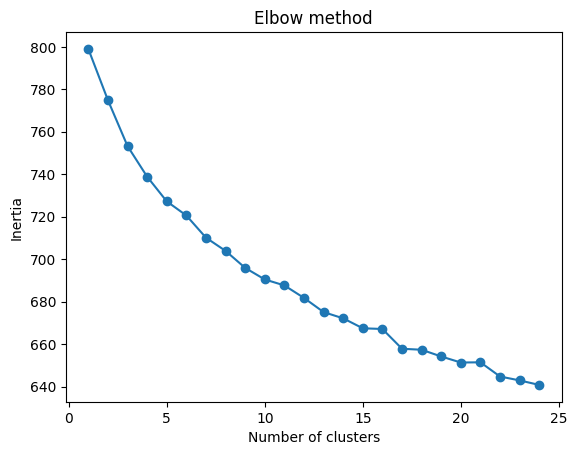

In [ ]:
from sklearn.cluster import KMeans

data = embeddings
inertias = []

for i in range(1,25):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,25), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from gensim import corpora
nltk.download('stopwords')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
import re

import spacy
nlp = spacy.load('en_core_web_sm')

repeats = ['offensive','language','text','category','individual','message', 'summary']
stop_words2 = stop_words + repeats

def preprocess(texts):
  texts = [re.sub(r'[^\w\s]', '', text) for text in texts]
  docs = [nlp(text) for text in texts]#nlp(text)
  lemmatized_tokens = [[token.lemma_ for token in doc] for doc in docs]
  text = [' '.join(lemmatized_token) for lemmatized_token in lemmatized_tokens]

  texts = [[word for word in document.lower().split() if word not in stop_words2]
      for document in text]

  frequency = defaultdict(int)
  for text in texts:
      for token in text:
          frequency[token] += 1

  texts = [
      [token for token in text if frequency[token] > 1]
      for text in texts]

  dictionary = corpora.Dictionary(texts)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from gensim import models
dictionary, corpus = preprocess(offensiveness_reasons)

In [ ]:
lsi = models.LdaModel(corpus, id2word=dictionary, num_topics=10)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim_models.prepare(lsi, corpus, dictionary)

pyLDAvis.display(vis)

In [ ]:
with open('topic_file', 'w') as topic_file:
    topics=lsi.top_topics(corpus)
    topic_file.write('\n'.join('%s %s' %topic for topic in topics))

# New Section

In [ ]:
df = pd.read_csv('potato_dataset_llamallm.csv')

In [ ]:
df

In [ ]:
import re

explanation_offensiveness_diff = []
noexplanation_offensiveness_diff = []

for index, row in df.iterrows():
  explanation_offensiveness_diff.append(abs(row['explanation scores'] - row['mean ranking']))
  noexplanation_offensiveness_diff.append(abs(int(row['no explanation']) - row['mean ranking']))

In [ ]:
print('Offensiveness dataset Llama')
print("The average difference between the LLM explained scores and the human scores are " + str(np.mean(explanation_offensiveness_diff)))
print("The average difference between the LLM unexplained scores and the human scores are " + str(np.mean(noexplanation_offensiveness_diff)))

# New Section

In [ ]:
offensiveness_llm = pd.read_csv('potato_politeness_llm.csv')

In [ ]:
noex = []
ex = []

for index, row in offensiveness_data.iterrows():
  #print(offensiveness_llm.iloc[offensiveness_llm.index[offensiveness_llm['id'] == row['instance_id']][0]])
  noex.append(offensiveness_llm.iloc[offensiveness_llm.index[offensiveness_llm['id'] == row['instance_id']][0]]['no explanation'])
  ex.append(offensiveness_llm.iloc[offensiveness_llm.index[offensiveness_llm['id'] == row['instance_id']][0]]['explanation scores'])

In [ ]:
offensiveness_data['no explanation'] = noex
offensiveness_data['explanation'] = ex

In [ ]:
noex_posts = []
ex_posts = []

for index, row in offensiveness_data.iterrows():
  if(row['offensiveness'] - row['no explanation'] >= 3):
    noex_posts.append(row['text'])
  if(row['offensiveness'] - row['explanation'] >= 3):
    ex_posts.append(row['text'])

In [ ]:
noex_explanation = []
ex_explanation = []

for x in noex_posts:
  noex_explanation.append(AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + x + "\"\n\nSummarize the above text and why it is polite.")) #If it is offensive, explain why and pick which of the following categories of offensive messages it belongs to:\nOffensive Language\nAbusive Language\nHate or Discriminatory Speech\nAggressiveness"))

In [ ]:
for x in range(len(ex_posts)):
  ex_explanation.append(AIquery(model="gpt-4o-mini", n=1, prompt = "Text: \"" + ex_posts[x] + "\"\n\nSummarize the above text and why it is polite."))# If it is offensive, explain why and pick which of the following categories of offensive messages it belongs to:\nOffensive Language\nAbusive Language\nHate or Discriminatory Speech\nAggressiveness"))
  print(str(x) + "/" + str(len(ex_posts)))

0/206
1/206
2/206
3/206
4/206
5/206
6/206
7/206
8/206
9/206
10/206
11/206
12/206
13/206
14/206
15/206
16/206
17/206
18/206
19/206
20/206
21/206
22/206
23/206
24/206
25/206
26/206
27/206
28/206
29/206
30/206
31/206
32/206
33/206
34/206
35/206
36/206
37/206
38/206
39/206
40/206
41/206
42/206
43/206
44/206
45/206
46/206
47/206
48/206
49/206
50/206
51/206
52/206
53/206
54/206
55/206
56/206
57/206
58/206
59/206
60/206
61/206
62/206
63/206
64/206
65/206
66/206
67/206
68/206
69/206
70/206
71/206
72/206
73/206
74/206
75/206
76/206
77/206
78/206
79/206
80/206
81/206
82/206
83/206
84/206
85/206
86/206
87/206
88/206
89/206
90/206
91/206
92/206
93/206
94/206
95/206
96/206
97/206
98/206
99/206
100/206
101/206
102/206
103/206
104/206
105/206
106/206
107/206
108/206
109/206
110/206
111/206
112/206
113/206
114/206
115/206
116/206
117/206
118/206
119/206
120/206
121/206
122/206
123/206
124/206
125/206
126/206
127/206
128/206
129/206
130/206
131/206
132/206
133/206
134/206
135/206
136/206
137/206
138/20

In [ ]:
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from gensim import corpora
nltk.download('stopwords')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
import re

import spacy
nlp = spacy.load('en_core_web_sm')

#repeats = ['offensive','language','text','category','individual','message', 'summary', 'express', 'could']
stop_words2 = stop_words + repeats

def preprocess(texts):
  texts = [re.sub(r'[^\w\s]', '', text) for text in texts]
  docs = [nlp(text) for text in texts]#nlp(text)
  lemmatized_tokens = [[token.lemma_ for token in doc] for doc in docs]
  text = [' '.join(lemmatized_token) for lemmatized_token in lemmatized_tokens]

  texts = [[word for word in document.lower().split() if word not in stop_words2]
      for document in text]

  frequency = defaultdict(int)
  for text in texts:
      for token in text:
          frequency[token] += 1

  texts = [
      [token for token in text if frequency[token] > 1]
      for text in texts]

  dictionary = corpora.Dictionary(texts)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models
dictionary, corpus = preprocess(noex_explanation)

lsi = models.LdaModel(corpus, id2word=dictionary, num_topics=5)

pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim_models.prepare(lsi, corpus, dictionary)

pyLDAvis.display(vis)

In [ ]:
from gensim import models
import pyLDAvis
import pyLDAvis.gensim_models
dictionary, corpus = preprocess(ex_explanation)

lsi = models.LdaModel(corpus, id2word=dictionary, num_topics=5)

pyLDAvis.enable_notebook(local=True)
vis = pyLDAvis.gensim_models.prepare(lsi, corpus, dictionary)

pyLDAvis.display(vis)

In [ ]:
noex_category = []
for x in range(len(noex_posts)):
  noex_category.append(AIHistoryquery('Text: \"' + noex_posts[x] + '\"\n\nSummarize the above text and why it is offensive. If it is offensive, explain why and pick which of the following categories of offensive messages it belongs to:\nOffensive Language\nAbusive Language\nHate or Discriminatory Speech\nAggressiveness', noex_explanation[x], 'Based on the above response, which of the following categories does the post fall into: \nOffensive Language\nAbusive Language\nHate or Discriminatory Speech\nAggressiveness'))

In [ ]:
ex_category = []
for x in range(len(ex_posts)):
  ex_category.append(AIHistoryquery('Text: \"' + ex_posts[x] + '\"\n\nSummarize the above text and why it is offensive. If it is offensive, explain why and pick which of the following categories of offensive messages it belongs to:\nOffensive Language\nAbusive Language\nHate or Discriminatory Speech\nAggressiveness', ex_explanation[x], 'Based on the above response, which of the following categories does the post fall into: \nOffensive Language\nAbusive Language\nHate or Discriminatory Speech\nAggressiveness'))

In [ ]:
import re

In [ ]:
noex_category[10]

'The post does not fall into any of the categories you provided: Offensive Language, Abusive Language, Hate or Discriminatory Speech, or Aggressiveness. It is a positive statement about the game "Donkey Kong Country 2" and does not contain any offensive or negative content.'

In [ ]:
re.findall(r'\*\*(.*?)\*\*', noex_explanation[0])

[]

In [ ]:
noex_reason = []
ex_reason = []

for x in ex_category:
  try:
    ex_reason.append(re.findall(r'\*\*(.*?)\*\*', x)[-1])
  except:
    ex_reason.append('none')

for x in noex_category:
  try:
    noex_reason.append(re.findall(r'\*\*(.*?)\*\*', x)[-1])
  except:
    noex_reason.append('none')

In [ ]:
noex_reason

['Hate or Discriminatory Speech',
 'Offensive Language',
 'Offensive Language',
 'Hate or Discriminatory Speech',
 'Offensive Language',
 'Hate or Discriminatory Speech',
 'Aggressiveness',
 'Aggressiveness',
 'Aggressiveness',
 'none',
 'none',
 'Offensive Language',
 'none',
 'none',
 'Aggressiveness',
 'none',
 'none',
 'Abusive Language',
 'none',
 'none',
 'Aggressiveness',
 'Hate or Discriminatory Speech',
 'Offensive Language',
 'Aggressiveness',
 'Offensive Language',
 'none',
 'none',
 'Hate or Discriminatory Speech',
 'Offensive Language',
 'Aggressiveness',
 'Aggressiveness',
 'none',
 'none',
 'none',
 'Aggressiveness',
 'none',
 'Hate or Discriminatory Speech',
 'Offensive Language',
 'none',
 'Aggressiveness',
 'Abusive Language',
 'Abusive Language',
 'none',
 'none',
 'Aggressiveness',
 'none',
 'Aggressiveness',
 'Offensive Language',
 'none',
 'Aggressiveness',
 'Aggressiveness',
 'Offensive Language',
 'Offensive Language',
 'Offensive Language',
 'Aggressiveness',
 

In [ ]:
for x in range(len(noex_reason)):
  noex_reason[x] = re.sub('\.', '', noex_reason[x])

for x in range(len(ex_reason)):
  ex_reason[x] = re.sub('\.', '', ex_reason[x])

<>:2: DeprecationWarning: invalid escape sequence '\.'
<>:5: DeprecationWarning: invalid escape sequence '\.'
<>:2: DeprecationWarning: invalid escape sequence '\.'
<>:5: DeprecationWarning: invalid escape sequence '\.'
/tmp/ipython-input-79-1732589973.py:2: DeprecationWarning: invalid escape sequence '\.'
  noex_reason[x] = re.sub('\.', '', noex_reason[x])
/tmp/ipython-input-79-1732589973.py:5: DeprecationWarning: invalid escape sequence '\.'
  ex_reason[x] = re.sub('\.', '', ex_reason[x])


In [ ]:
from collections import Counter

for x in range(len(Counter(noex_reason).keys())):
  print(list(Counter(noex_reason).keys())[x] + ": " + str(list(Counter(noex_reason).values())[x]))

print("\n")
for x in range(len(Counter(ex_reason).keys())):
  print(list(Counter(ex_reason).keys())[x] + ": " + str(list(Counter(ex_reason).values())[x]))

Hate or Discriminatory Speech: 29
Offensive Language: 48
Aggressiveness: 45
none: 50
Abusive Language: 18


Aggressiveness: 56
Hate or Discriminatory Speech: 53
Offensive Language: 72
none: 55
Abusive Language: 14


In [ ]:
Counter(noex_reason).keys()

dict_keys(['Hate or Discriminatory Speech', 'Offensive Language', 'Aggressiveness', 'none', 'Abusive Language', 'Aggressiveness.', 'Offensive Language.'])

In [ ]:
#send results with text id